In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot
import igraph
import scvelo as scv 
import loompy as lmp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix 
import os 

C:\Users\skeam\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
import pooch

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.24.3 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.2 pynndescent==0.5.11


In [3]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

In [18]:
adata = sc.read_10x_mtx(
    "filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache\filtered_gene_bc_matrices-hg19-matrix.h5ad


In [19]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [21]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [22]:
adata.var_names

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

normalizing counts per cell
    finished (0:00:00)


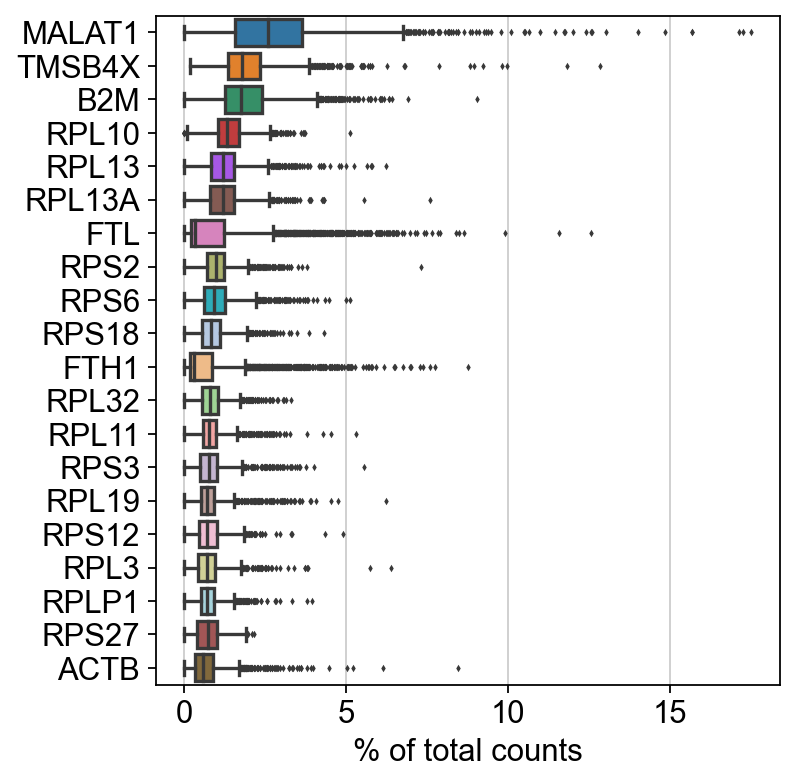

In [20]:
# preprocessing 
sc.pl.highest_expr_genes(adata, n_top=20)

In [23]:
#Basic filtering 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [24]:
# Let’s assemble some information about mitochondrial genes, which are important for quality control.
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [26]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795


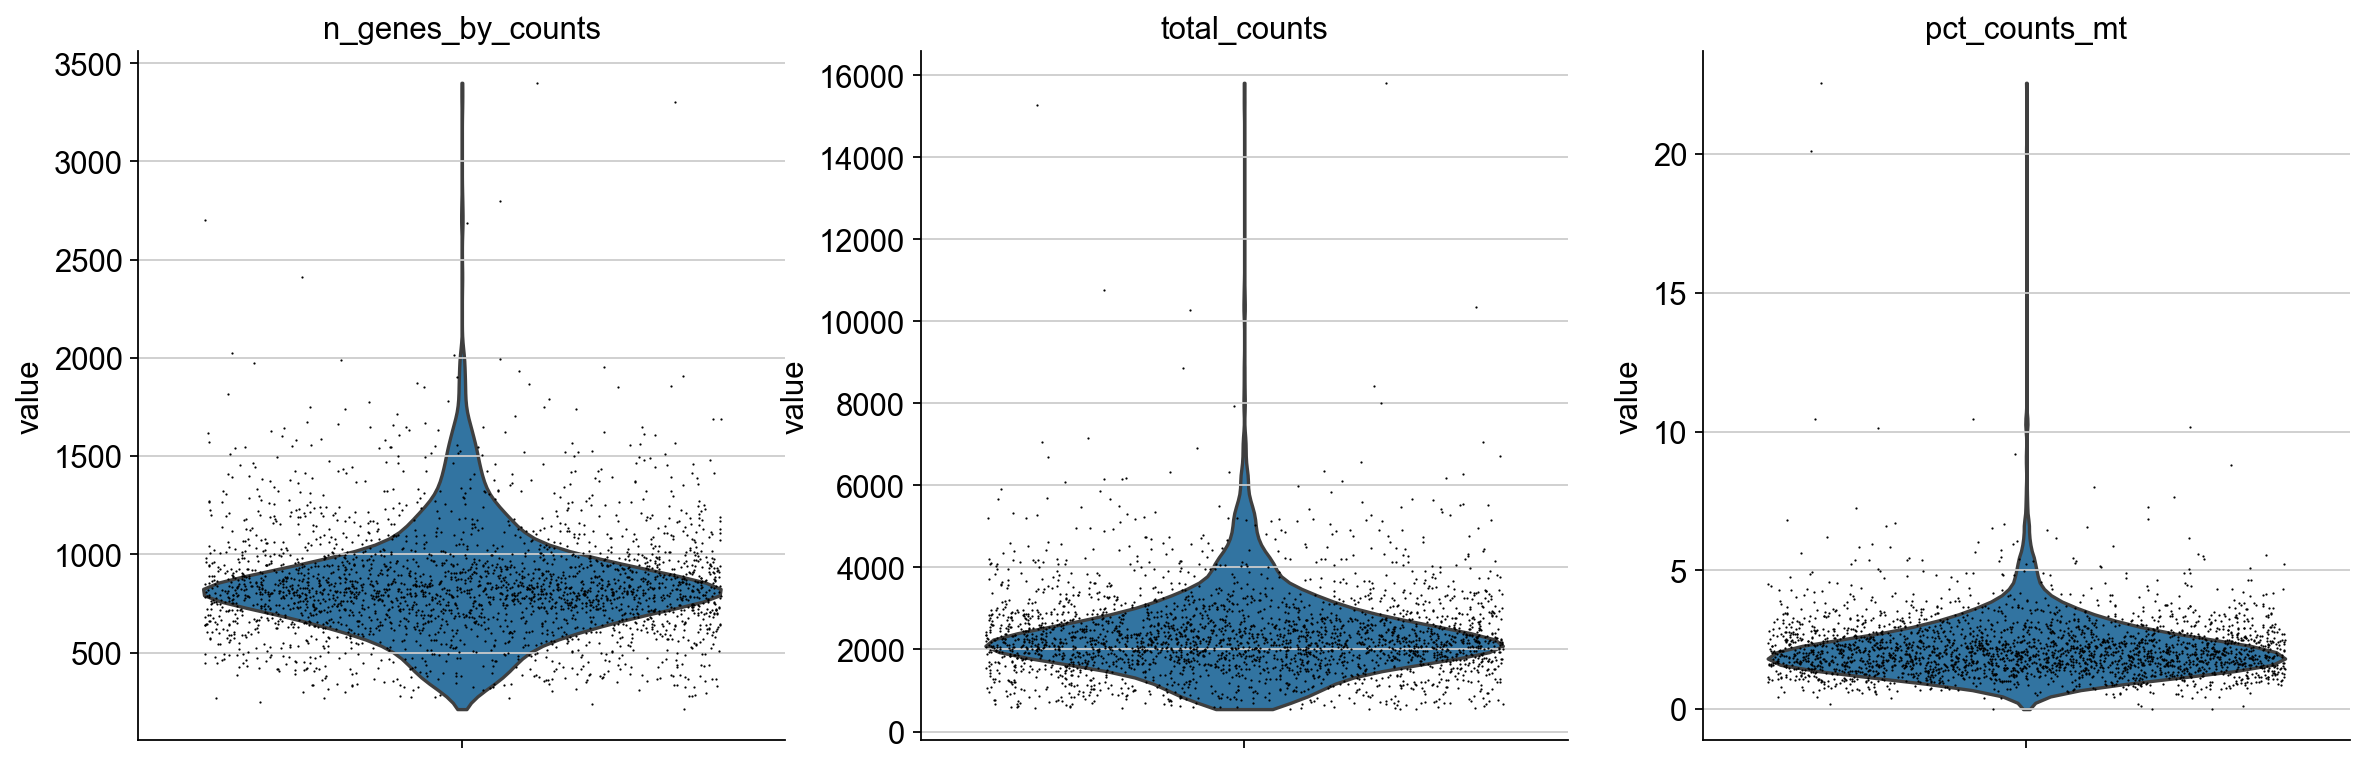

In [25]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [27]:
adata= adata[adata.obs.n_genes_by_counts<2000, :]
adata= adata[adata.obs.total_counts<6000, :]
adata= adata[adata.obs.pct_counts_mt<10, :]

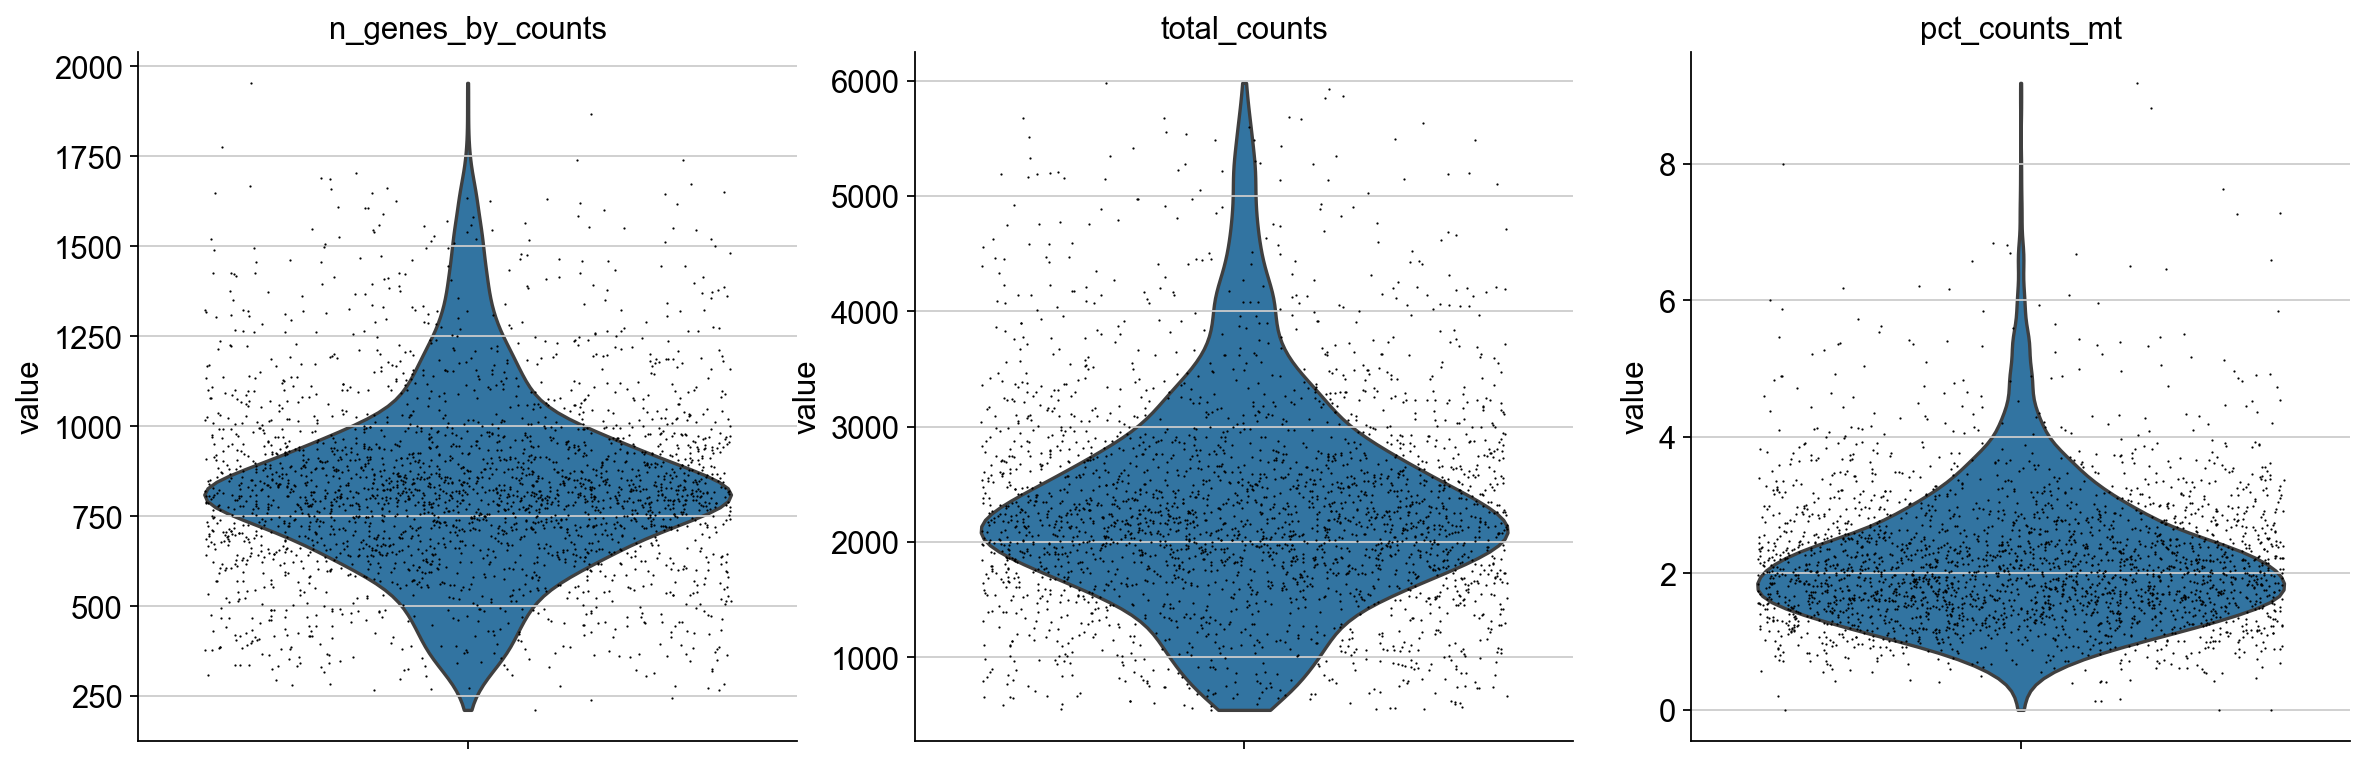

In [28]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [31]:
adata.write("adata_preprocessing.h5ad")

In [32]:
adata= sc.read_h5ad("adata_preprocessing.h5ad")

In [33]:
#Part 2=== Cell clustering!! 
#Total-count normalize (library-size correct) the data matrix 
# to 10,000 reads per cell, so that counts become comparable among cells. 
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [34]:
sc.pp.log1p(adata)

In [35]:
#identify highly variable genes 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


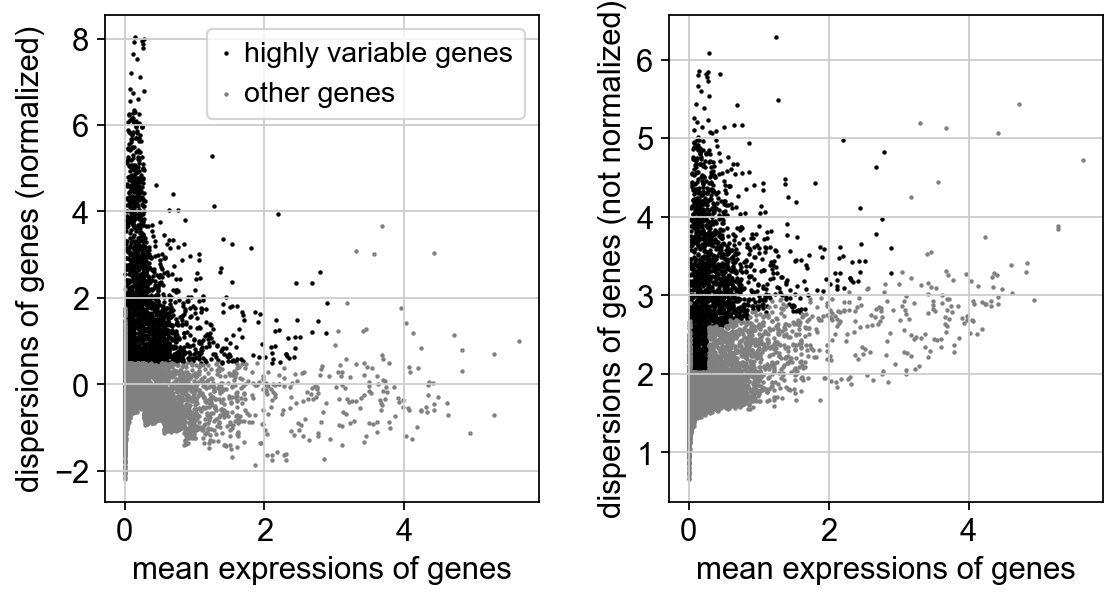

In [36]:
sc.pl.highly_variable_genes(adata)

In [37]:
#Actual filtering 
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:16)


In [38]:
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [39]:
# Principal component analysis
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


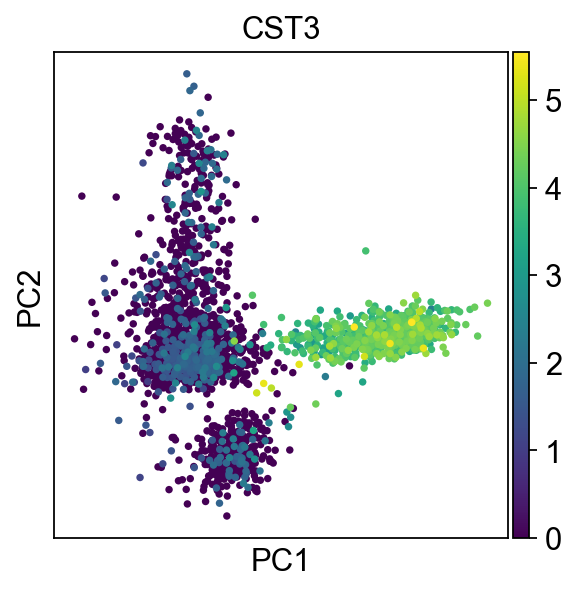

In [40]:
sc.pl.pca(adata, color="CST3")

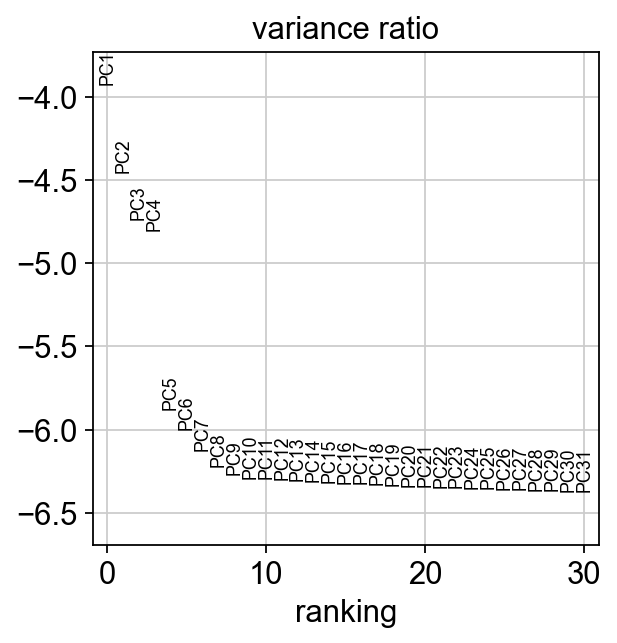

In [41]:
sc.pl.pca_variance_ratio(adata, log=True)

In [42]:
#Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [43]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [44]:
# Embedding the neighborhood graph  
sc.tl.leiden(adata, resolution=1.0)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


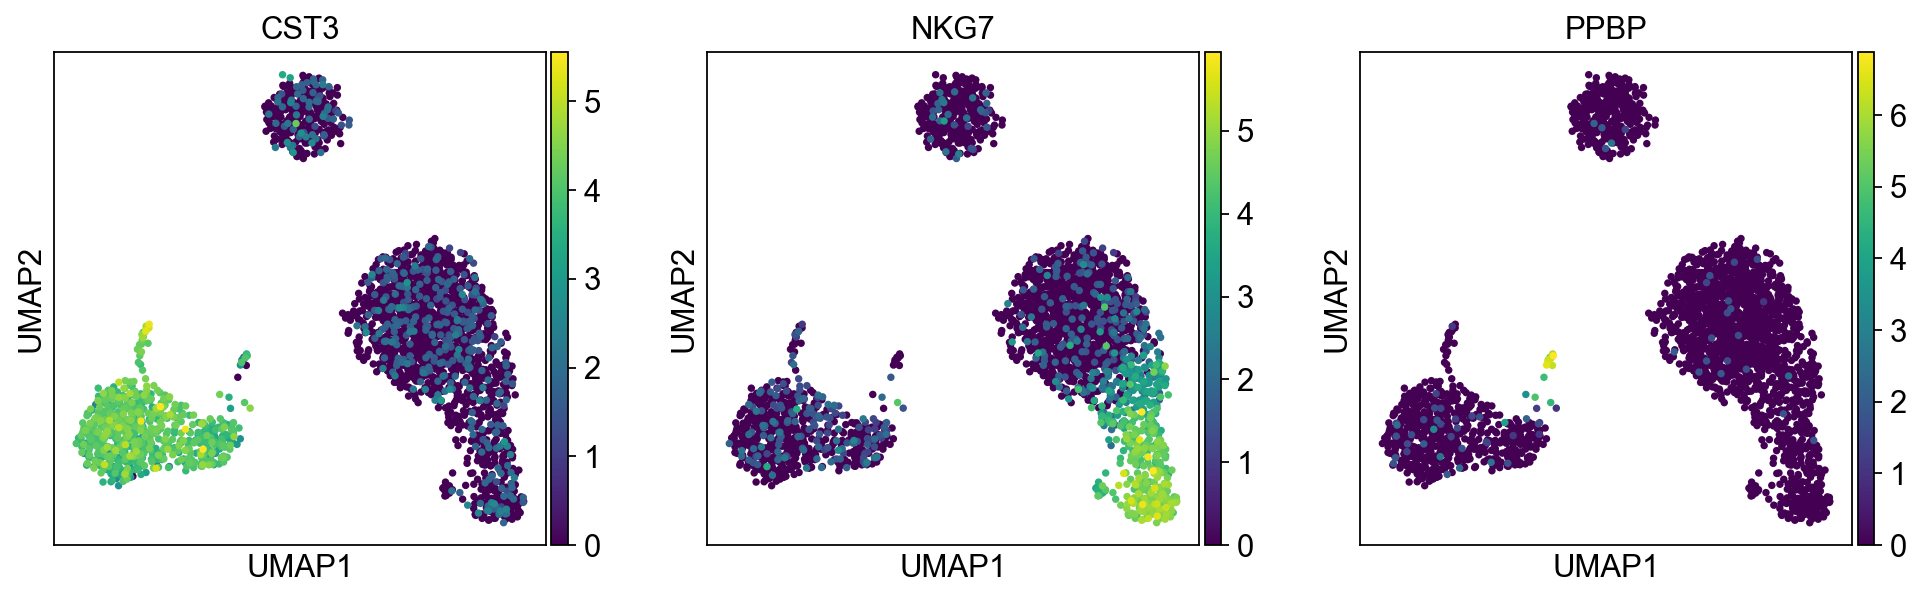

In [45]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

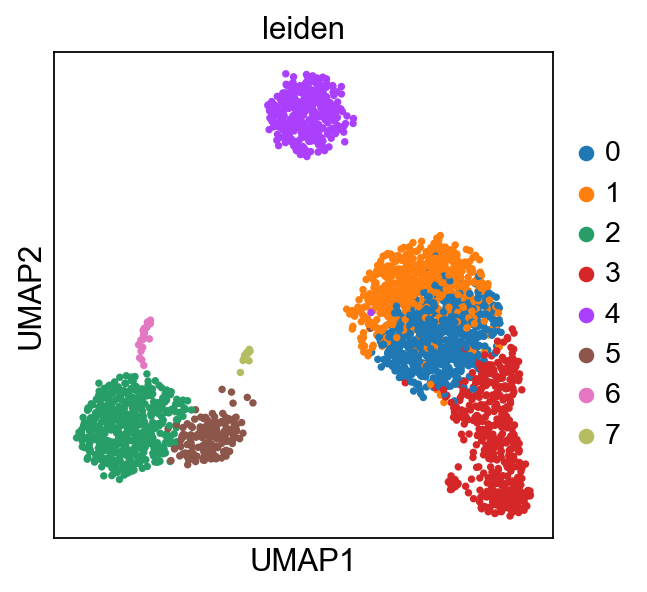

In [46]:
sc.pl.umap(adata, color="leiden")

In [47]:
# Actually mark the cell types.
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

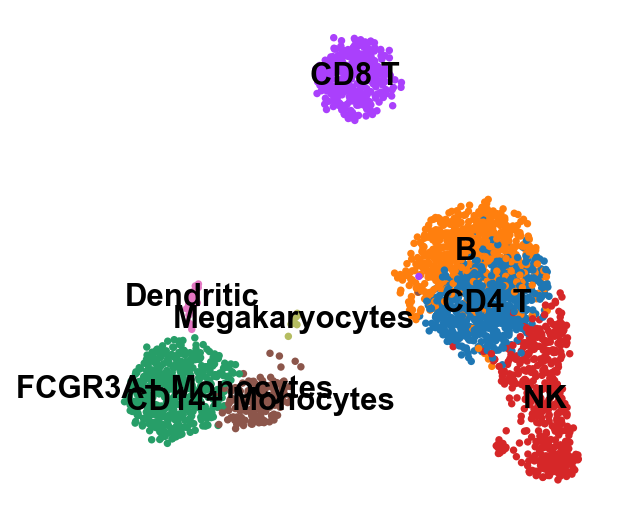

In [56]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

In [49]:
adata

AnnData object with n_obs × n_vars = 2668 × 1846
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [50]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,B
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,CD8 T
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,CD4 T
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,FCGR3A+ Monocytes
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,NK
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436,FCGR3A+ Monocytes
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422,CD8 T
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150,CD8 T
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795,CD8 T


In [51]:
adata.write("final_preprocessing.h5ad")

In [57]:
adata.obs.leiden.unique().tolist()

['B',
 'CD8 T',
 'CD4 T',
 'FCGR3A+ Monocytes',
 'NK',
 'CD14+ Monocytes',
 'Dendritic',
 'Megakaryocytes']

# Subset cell cluster 

In [62]:
bdata= adata[adata.obs.leiden == "B"]

In [63]:
bdata

View of AnnData object with n_obs × n_vars = 575 × 1846
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [64]:
bdata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,B
AAAGAGACGAGATA-1,866,864,2410.0,26.0,1.078838,B
AAAGAGACGGCATT-1,335,335,792.0,19.0,2.398990,B
AAAGCCTGTATGCG-1,1014,1013,2928.0,50.0,1.707650,B
AAAGTTTGTAGAGA-1,417,417,1102.0,17.0,1.542650,B
...,...,...,...,...,...,...
TTGAGGTGGACGGA-1,712,712,2011.0,21.0,1.044257,B
TTGCTAACCACTCC-1,656,652,1939.0,44.0,2.269211,B
TTGGGAACTGAACC-1,858,857,2651.0,56.0,2.112410,B
TTGGTACTCTTAGG-1,752,750,2926.0,51.0,1.742994,B


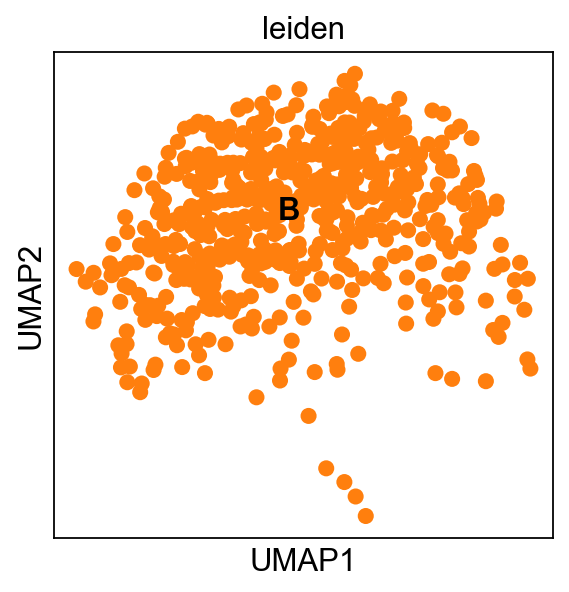

In [65]:
sc.pl.umap(bdata, color="leiden", legend_loc= "on data")

In [68]:
sc.tl.leiden(bdata, resolution= 0.5)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


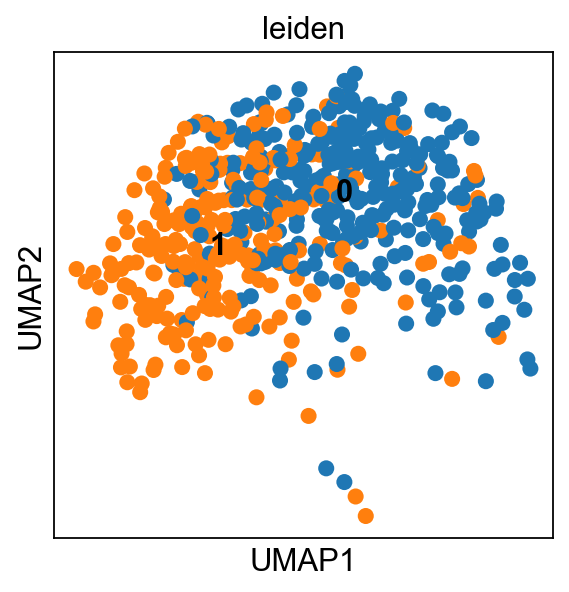

In [69]:
sc.pl.umap(bdata, color= "leiden", legend_loc= "on data")

In [80]:
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
sc.tl.leiden(bdata, resolution= 0.7)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


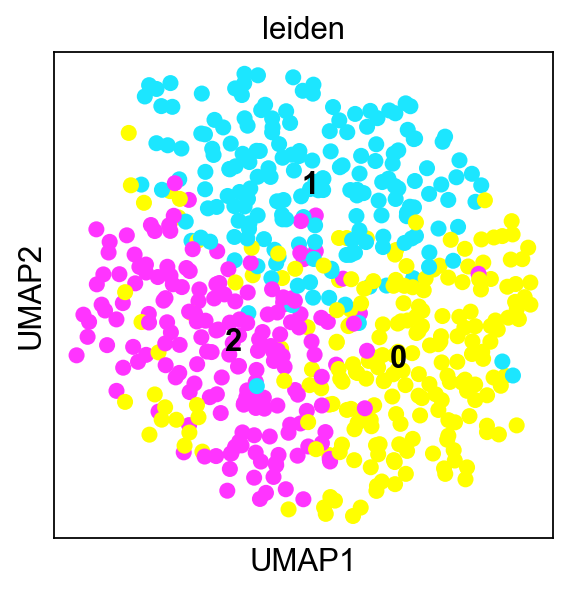

In [81]:
sc.pl.umap(bdata, color="leiden", legend_loc= "on data")

In [95]:
# subset two more clusters! 
M= ["CD4 T", "NK"]
cdata= adata[adata.obs.leiden.isin(M)]

In [96]:
cdata.obs.leiden.unique().tolist()

['CD4 T', 'NK']

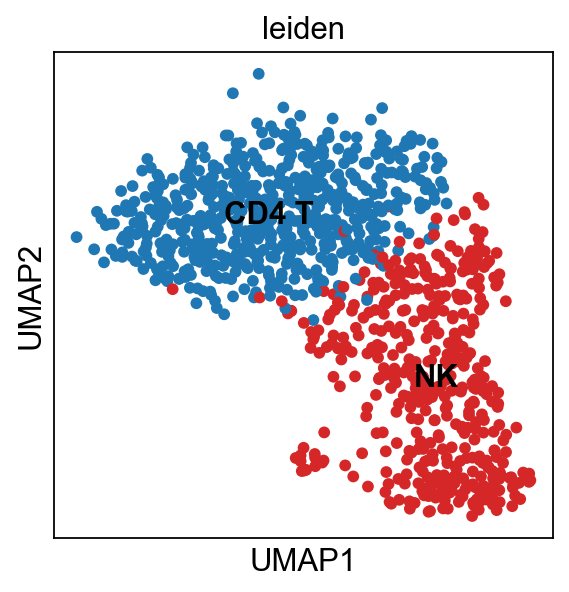

In [97]:
sc.pl.umap(cdata, color= "leiden", legend_loc= "on data")

In [98]:
sc.pp.neighbors(cdata)
sc.tl.umap(cdata)
sc.tl.leiden(cdata, resolution= 0.5)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


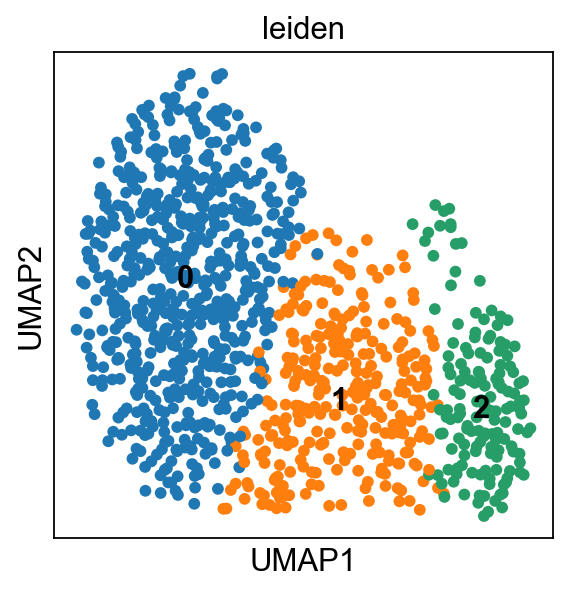

In [99]:
sc.pl.umap(cdata, color= "leiden", legend_loc= "on data")

In [100]:
# Convert scanpy to seurat obj! 
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot
import igraph
import scvelo as scv 
import loompy as lmp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix 
import os 

In [101]:
adata= sc.read_h5ad("230114_hPCLS_perturbation.h5ad")

In [102]:
adata

AnnData object with n_obs × n_vars = 63581 × 17343
    obs: 'condition', 'modality', 'patient', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group', 'sample'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'QC_group_colors', 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'dendrogram_cell_type', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'modality_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'sample_colors', 'timepoint_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

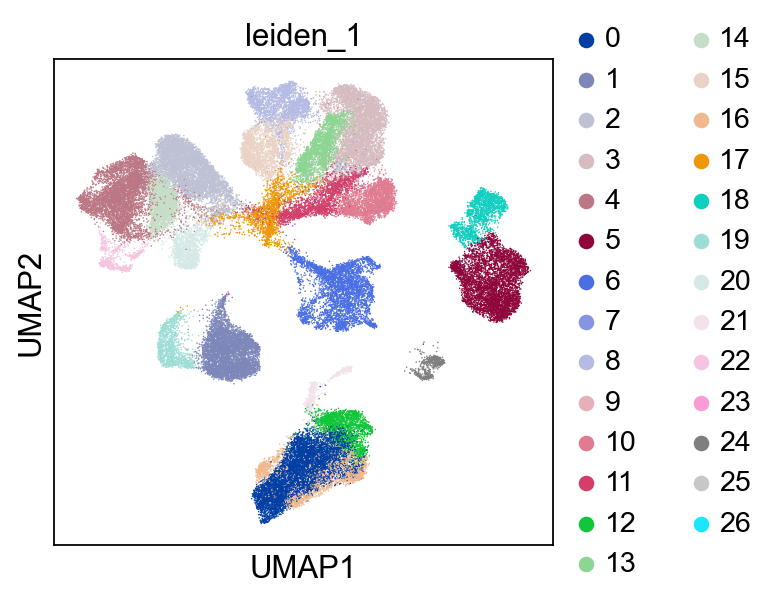

In [103]:
sc.pl.umap(adata, color= "leiden_1")

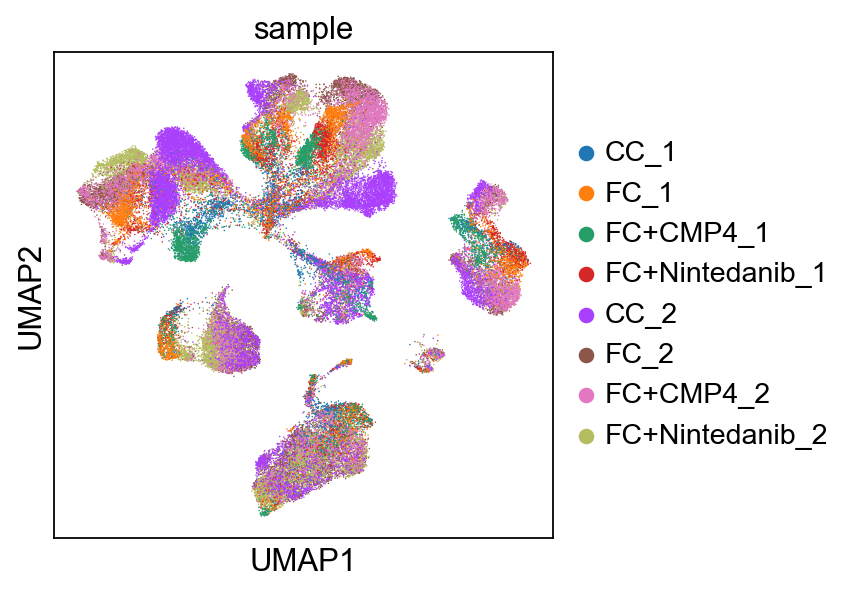

In [104]:
sc.pl.umap(adata, color="sample")

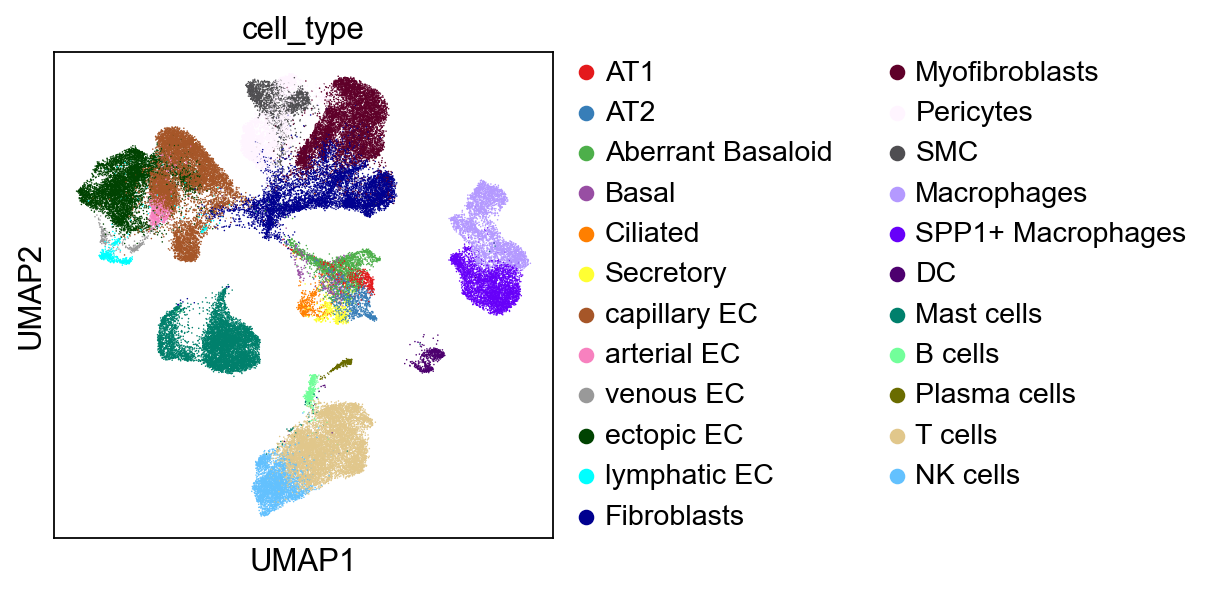

In [105]:
sc.pl.umap(adata, color="cell_type")

In [107]:
adata= adata.raw.to_adata()

In [110]:
io.mmwrite("matrix",adata.X.T)

In [111]:
adata.obs_names

Index(['muc31175_AAACCCAAGATCCCGC', 'muc31175_AAACCCAAGTAAAGCT',
       'muc31175_AAACCCACAAGTTGGG', 'muc31175_AAACCCACACCAAAGG',
       'muc31175_AAACCCACACCTCGTT', 'muc31175_AAACCCACAGTTAAAG',
       'muc31175_AAACCCACATAGAATG', 'muc31175_AAACCCACATTACGGT',
       'muc31175_AAACCCACATTAGGAA', 'muc31175_AAACCCAGTACGAGTG',
       ...
       'muc24279_TTTCGATTCGTTATCT', 'muc24279_TTTGACTCAAAGCACG',
       'muc24279_TTTGACTGTAACATAG', 'muc24279_TTTGACTTCGAAGAAT',
       'muc24279_TTTGATCCAATTGAGA', 'muc24279_TTTGATCGTTAGTCGT',
       'muc24279_TTTGATCGTTCCCACT', 'muc24279_TTTGGAGCACGATAGG',
       'muc24279_TTTGTTGCAAGACAAT', 'muc24279_TTTGTTGTCGATACGT'],
      dtype='object', length=63581)

In [112]:
with open ("barcodes.tsv.gz", "w") as f: 
    for item in adata.obs_names:
        f.write(item + "\n")

In [113]:
adata.var_names

Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15',
       'AGRN', 'RNF223', 'C1orf159',
       ...
       'AL592183.1', 'AC007325.1', 'AC007325.4', 'AC007325.2', 'AL354822.1',
       'AC023491.2', 'AC004556.3', 'AC233755.1', 'AC240274.1', 'AC213203.1'],
      dtype='object', length=18073)

In [115]:
with open ("features.tsv.gz", "w") as f:
    for item in adata.var_names:
        f.write(item + "\n")

In [116]:
adata.obs

,condition,modality,patient,treatment,identifier,n_counts,n_genes,percent_mito,QC_group,doublet_scores,size_factors,leiden_1,leiden_2,cell_type,cell_type_group,sample
muc31175_AAACCCAAGATCCCGC,Fibrotic Cocktail,PCLS,2,FC,muc31175,735.0,481,0.073469,low,0.051087,0.101679,0,7,T cells,T cells,FC_2
muc31175_AAACCCAAGTAAAGCT,Fibrotic Cocktail,PCLS,2,FC,muc31175,4782.0,2074,0.035968,low,0.020891,0.772610,4,2,ectopic EC,vascular EC,FC_2
muc31175_AAACCCACAAGTTGGG,Fibrotic Cocktail,PCLS,2,FC,muc31175,1304.0,773,0.007669,low,0.027234,0.188760,1,0,Mast cells,Mast cells,FC_2
muc31175_AAACCCACACCAAAGG,Fibrotic Cocktail,PCLS,2,FC,muc31175,1986.0,1118,0.043807,low,0.164641,0.300193,1,0,Mast cells,Mast cells,FC_2
muc31175_AAACCCACACCTCGTT,Fibrotic Cocktail,PCLS,2,FC,muc31175,2049.0,986,0.060517,low,0.138672,0.283763,21,33,B cells,B cells,FC_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
muc24279_TTTGATCGTTAGTCGT,Fibrotic Cocktail,PCLS,1,FC,muc24279,10589.0,3476,0.014166,medium,0.050000,1.779824,2,5,capillary EC,capillary EC,FC_1
muc24279_TTTGATCGTTCCCACT,Fibrotic Cocktail,PCLS,1,FC,muc24279,658.0,438,0.004559,medium,0.047490,0.107031,17,18,Fibroblasts,Fibroblasts,FC_1
muc24279_TTTGGAGCACGATAGG,Fibrotic Cocktail,PCLS,1,FC,muc24279,5930.0,2419,0.037605,medium,0.038509,0.972865,15,14,Pericytes,SMC/Pericytes,FC_1
muc24279_TTTGTTGCAAGACAAT,Fibrotic Cocktail,PCLS,1,FC,muc24279,2786.0,1487,0.045226,medium,0.042802,0.472818,19,20,Mast cells,Mast cells,FC_1


In [117]:
adata.obs.to_csv("metadata.csv")

In [ ]:
# from here we can use seurat to read this python file! 
